**Importamos librerias**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib import style

import seaborn as sns
import os
import cv2
import random
np.random.seed(42)

import warnings
warnings.filterwarnings("ignore")
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

style.use('fivethirtyeight')

1.   **Conexión con google drive**
2.   **Asignación de rutas para los datos**
---

In [2]:
from google.colab import drive
drive.mount('/content/drive')

#rutas de test y train
data_dir = "/content/drive/MyDrive/Datasets"
train_path ='/content/drive/MyDrive/Datasets/Train'
test_path ='/content/drive/MyDrive/Datasets/Test'

Mounted at /content/drive


1.  **Contabilizamos el numero de categorias.**
2.  **Cambiar el tamaño de las imágenes a 30x30x3**
3.  **Asignamos nombres a las categorias**

In [3]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

classes = {0:'Letra A', 1:'Letra E', 2:'Letra I', 3:'Letra O', 4:'Letra U' }

**Visualizacion del conjunto de datos**

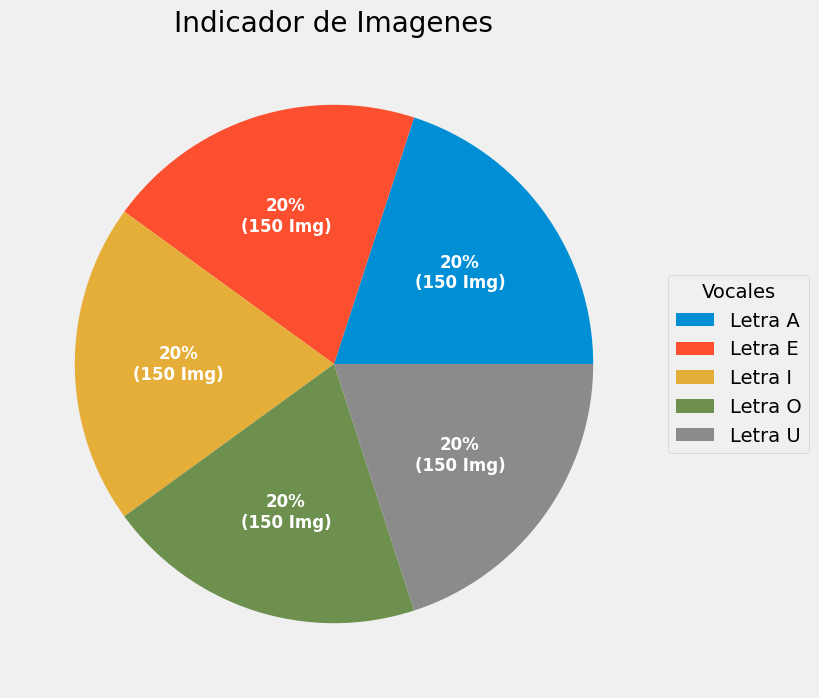

In [4]:
#Funcion para listar los nombres de las entradas en el directorio
folders = os.listdir(train_path)
train_number = []
class_num = []
for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)]) 

# Trazar el número de imágenes en cada clase    
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))
data = train_number
ingredients = class_num
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.0f}%\n({absolute:d} Img)"
wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data), textprops=dict(color="w"))
ax.legend(wedges, ingredients,
          title="Vocales",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=12, weight="bold")
ax.set_title("Indicador de Imagenes")
plt.show()

# plt.figure(figsize=(21,10))  
# plt.bar(class_num, train_number)
# plt.xticks(class_num, rotation='vertical')
# plt.show()



**Visualización de imágenes aleatorias a partir de datos de prueba**

In [9]:
test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,400))
for i in range(1,502):
    plt.subplot(100,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 20)
    plt.ylabel(rand_img.shape[0], fontsize = 20)
  

Output hidden; open in https://colab.research.google.com to view.

**Recopilación de datos de entrenamiento**

In [6]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)   
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Cambiando la lista a matriz numpy
image_data = np.array(image_data)
image_labels = np.array(image_labels)
print("Matriz numpy",image_data.shape, image_labels.shape)

#Mezclando los datos de entrenamiento
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

#print(shuffle_indexes)

Matriz numpy (750, 30, 30, 3) (750,)


**Dividir los datos en subconjuntos aleatorios de entrenamiento y prueba.**

In [7]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=5, shuffle=True)
X_train = X_train/255
X_val = X_val/255
print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (525, 30, 30, 3)
X_valid.shape (225, 30, 30, 3)
y_train.shape (525,)
y_valid.shape (225,)


**Convierte un vector de clase enteros en una matriz de clase binaria.**

In [8]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)
print(y_train.shape)
print(y_val.shape)

(525, 5)
(225, 5)


**Haciendo el modelo**

In [9]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, padding='same', kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=16, padding='same', kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=32, padding='same', kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=64, padding='same', kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),   

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),    
    keras.layers.Dense(5, activation='softmax')
])

In [10]:
lr = 0.01
epochs = 25

opt = keras.optimizers.Adam(learning_rate=lr,weight_decay=lr/(epochs*0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 15, 15, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0

In [11]:
aug = ImageDataGenerator(
    #validation_split=0.2,
    rotation_range=12,
    zoom_range=0.12,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.12,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))


Epoch 1/25
17/17 [==============================] - 3s 73ms/step - loss: 1.4030 - accuracy: 0.5657 - val_loss: 10.3926 - val_accuracy: 0.1644
Epoch 2/25
17/17 [==============================] - 1s 53ms/step - loss: 0.6271 - accuracy: 0.7714 - val_loss: 1.7549 - val_accuracy: 0.4667
Epoch 3/25
17/17 [==============================] - 1s 58ms/step - loss: 0.3986 - accuracy: 0.8495 - val_loss: 2.7821 - val_accuracy: 0.4933
Epoch 4/25
17/17 [==============================] - 1s 58ms/step - loss: 0.3654 - accuracy: 0.8667 - val_loss: 4.7566 - val_accuracy: 0.1822
Epoch 5/25
17/17 [==============================] - 1s 86ms/step - loss: 0.2389 - accuracy: 0.9219 - val_loss: 5.8806 - val_accuracy: 0.5556
Epoch 6/25
17/17 [==============================] - 2s 87ms/step - loss: 0.2350 - accuracy: 0.9295 - val_loss: 6.4584 - val_accuracy: 0.3556
Epoch 7/25
17/17 [==============================] - 1s 58ms/step - loss: 0.1567 - accuracy: 0.9429 - val_loss: 5.4655 - val_accuracy: 0.3822
Epoch 8/25
1

In [12]:
# Guardamos el modelo
model.save("Model_IA.h5")
model.save_weights("/content/drive/MyDrive/Datasets/output")

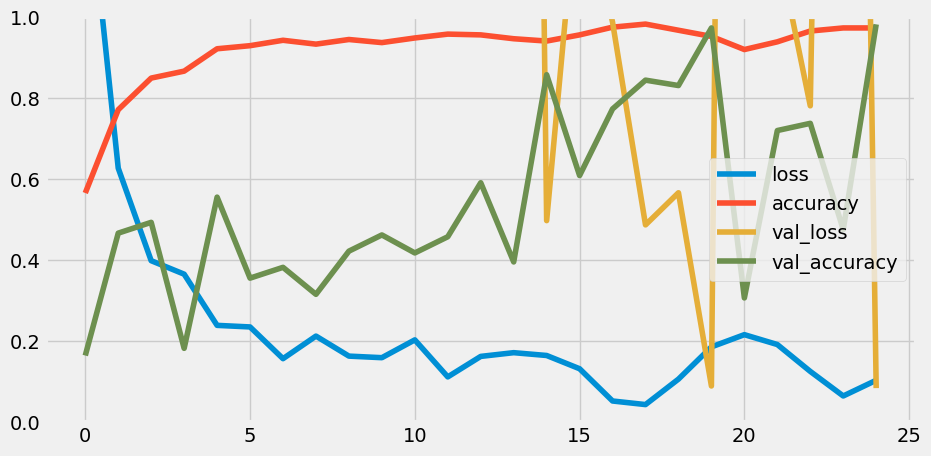

In [13]:
pd.DataFrame(history.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [14]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]
for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error en " + img)
X_test = np.array(data)
X_test = X_test/255

pred=np.argmax(model.predict(X_test),axis=1)
print('Exactitud de los datos de prueba: ',accuracy_score(labels, pred)*100)

24/24 [==============================] - 0s 11ms/step
Exactitud de los datos de prueba:  98.8


<Axes: >

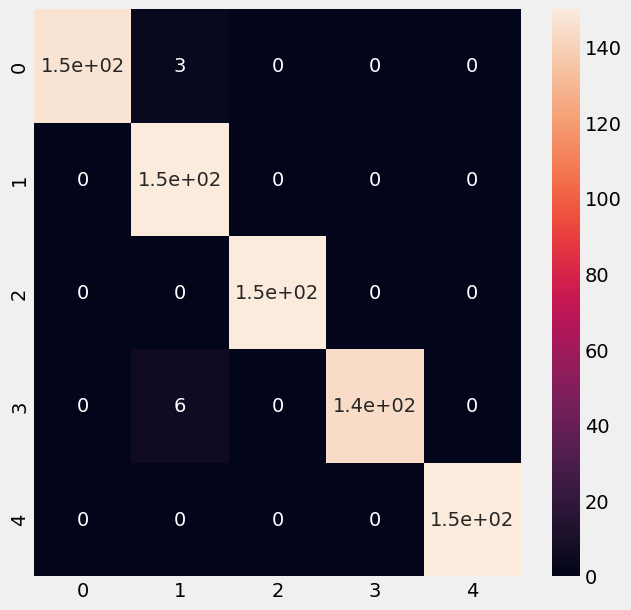

In [15]:
cf = confusion_matrix(labels, pred)
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True)

In [16]:
from sklearn.metrics import classification_report
print(classification_report(labels, pred.astype(int)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       150
           1       0.94      1.00      0.97       150
           2       1.00      1.00      1.00       150
           3       1.00      0.96      0.98       150
           4       1.00      1.00      1.00       150

    accuracy                           0.99       750
   macro avg       0.99      0.99      0.99       750
weighted avg       0.99      0.99      0.99       750



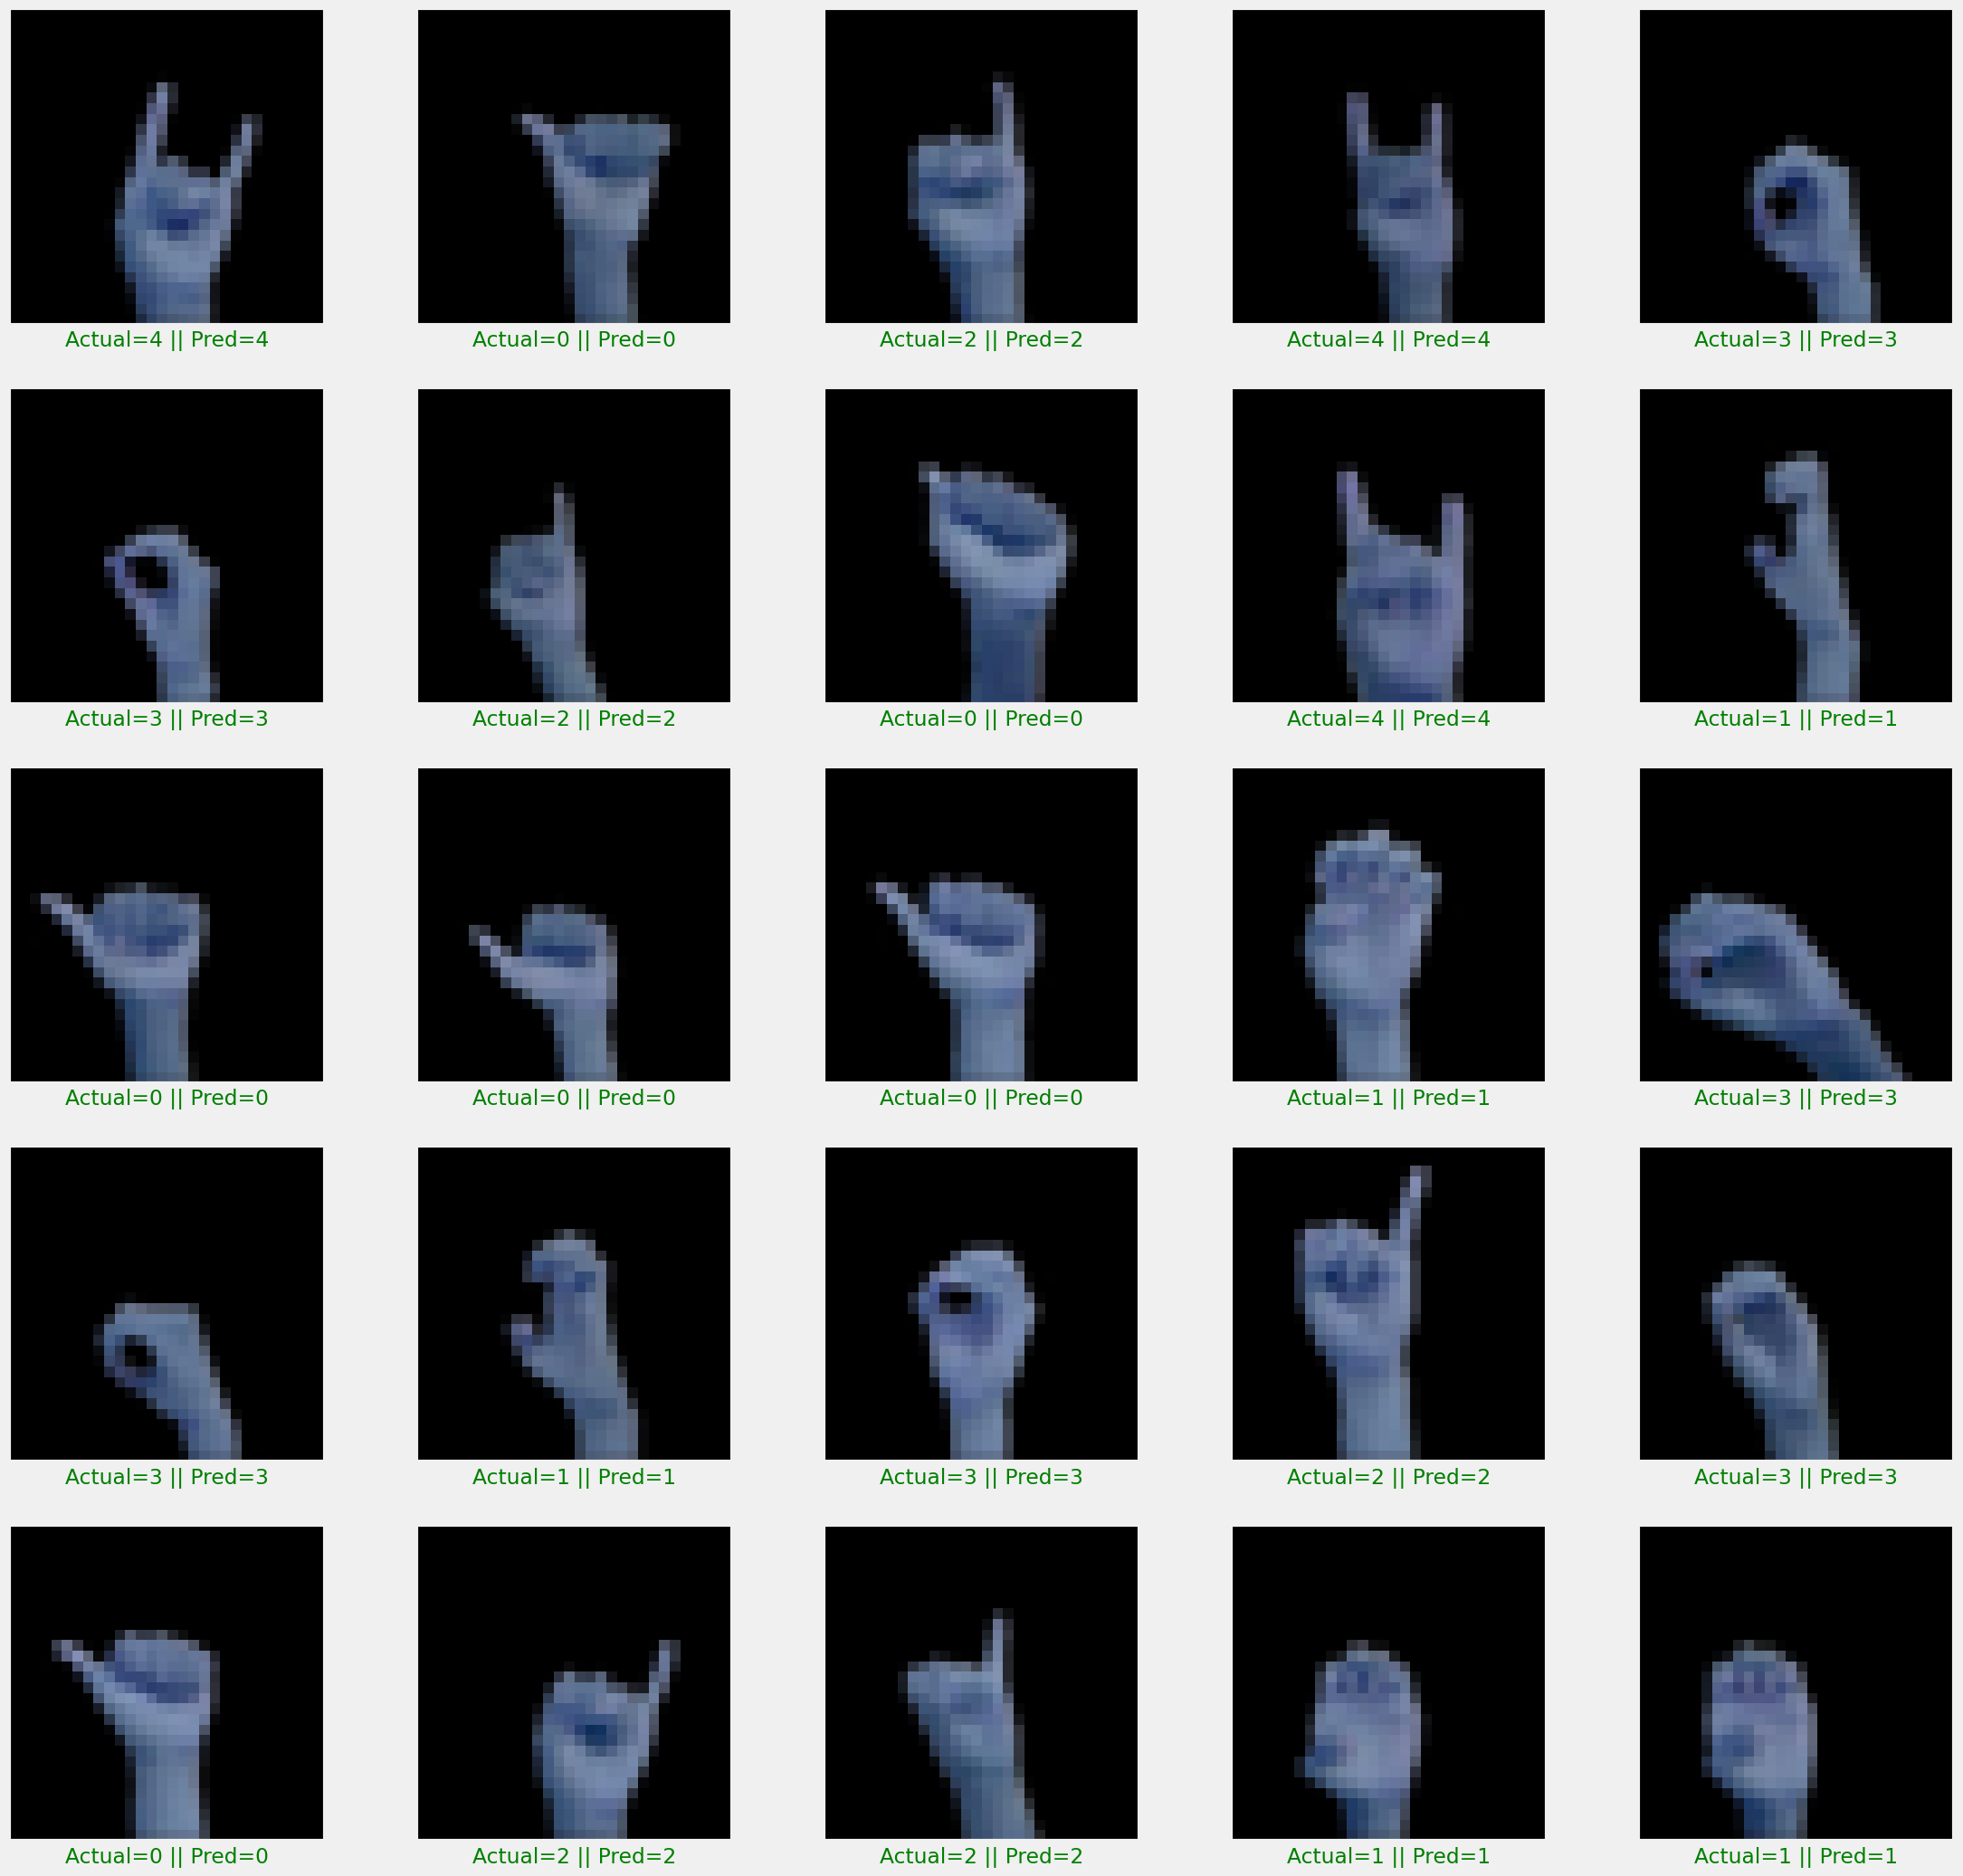

In [17]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction.astype(int) != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])    
   
plt.show()

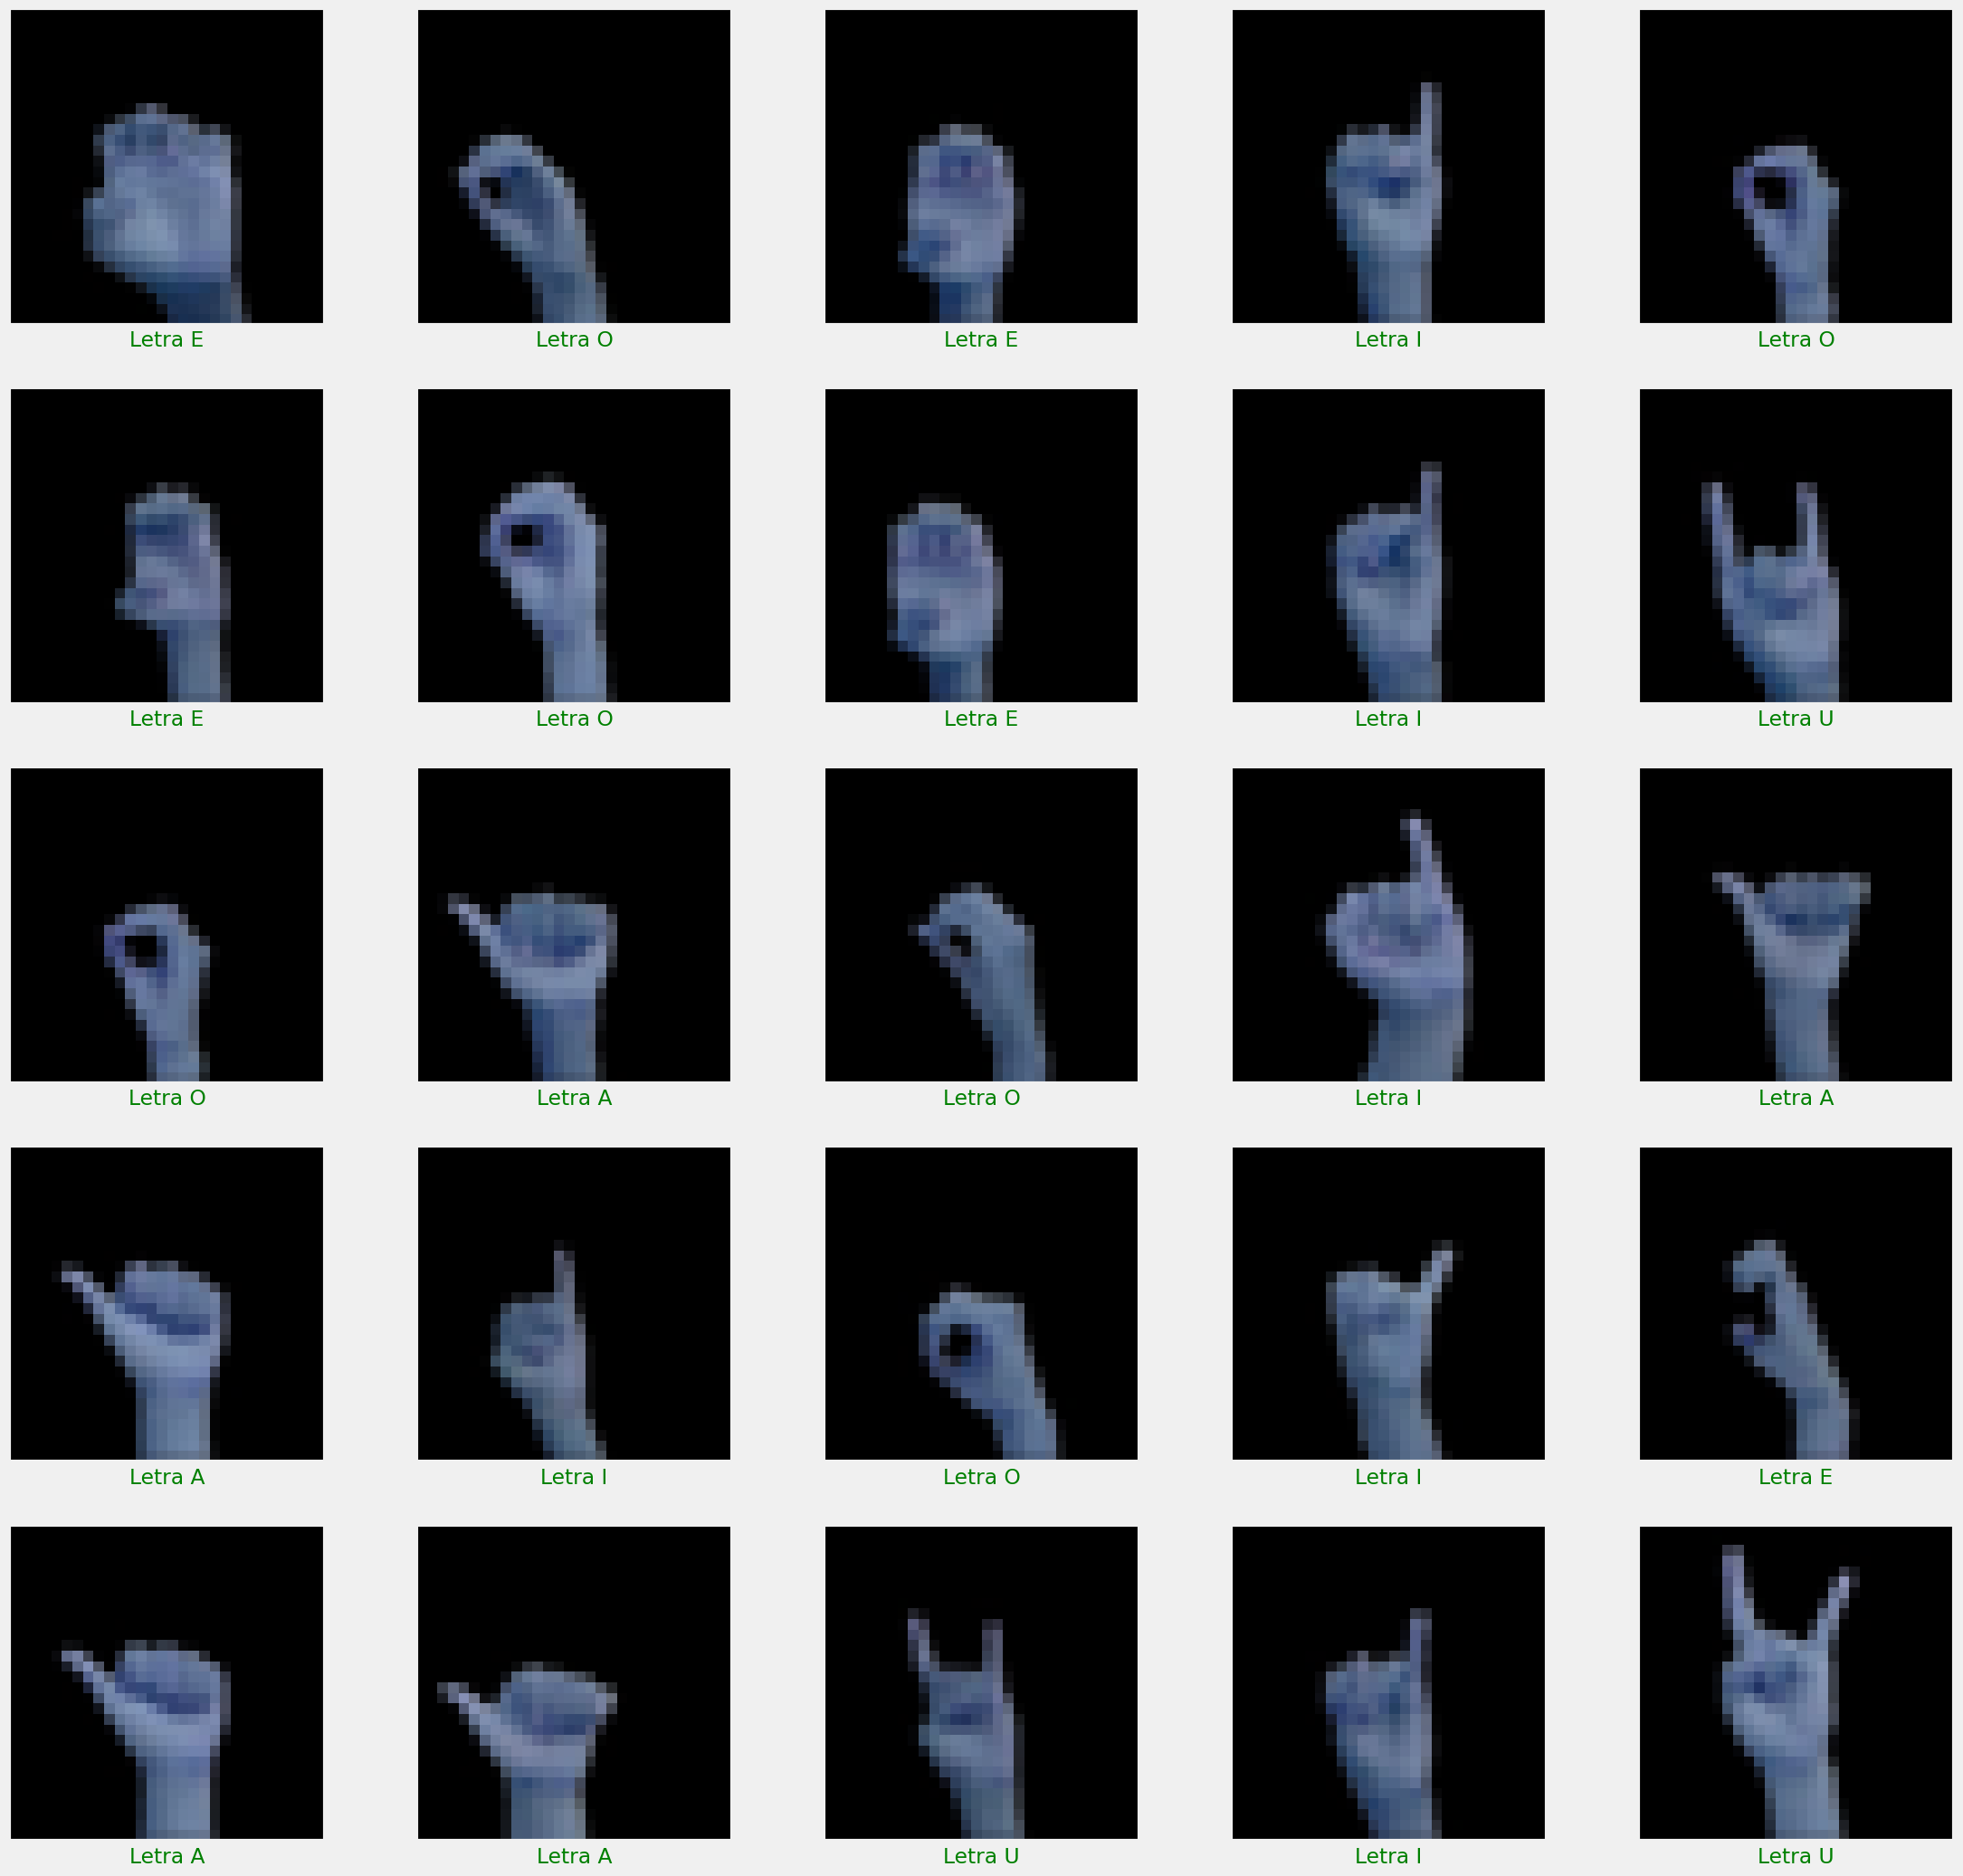

In [19]:
plt.figure(figsize = (25, 25))

# start_index = 75
start_index = 25
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction.astype(int) != actual:
        col = 'r'
    plt.xlabel('{}'.format(classes[prediction]), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()